In [1]:
import pandas as pd
data_directory = '../data/'
import seaborn as sns
sns.set_color_codes()
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pystan import StanModel
n_jobs = 4
from scipy.stats import norm, truncnorm, multivariate_normal, lognorm, gaussian_kde

In [11]:
empirical_data = pd.read_csv(data_directory+'time_series.csv',index_col=0)
empirical_data = empirical_data.reindex(arange(empirical_data.index[0],empirical_data.index[-1]+1))
metadata = pd.read_csv(data_directory+'time_series_metadata.csv')

# target_tech_names = metadata.ix[(metadata['Source']=='Magee_et_al'), 'Name']
# empirical_time_series = log(empirical_data[target_tech_names])

valid_time_series = sum(~empirical_time_series.ix[1975:].isnull())>3
valid_domains = metadata.set_index('Name').ix[valid_time_series.index[valid_time_series]]['Domain'].unique()

print("Number of valid domains: %i"%valid_domains.size)

Number of valid domains: 21


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


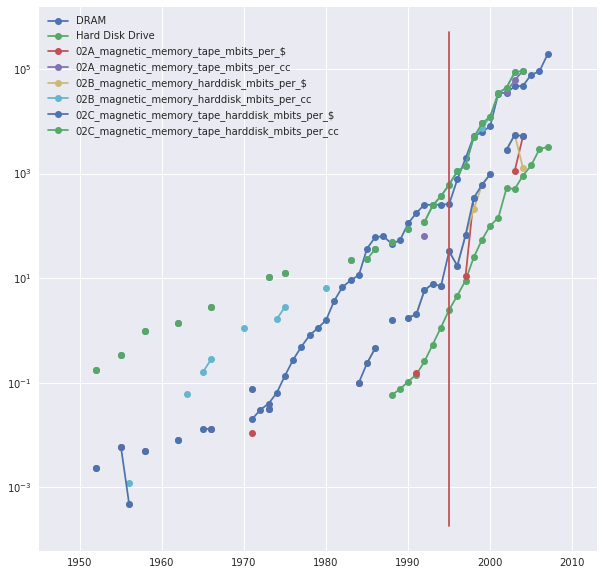

In [19]:
empirical_data[metadata.loc[metadata['Domain'] == 'MAGNETIC_INFO_STORAGE', 'Name'].values].plot(marker='o', figsize=(10,10))
yscale('log')
xlim(xmin=1945)
plot((1995, 1995), ylim())

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


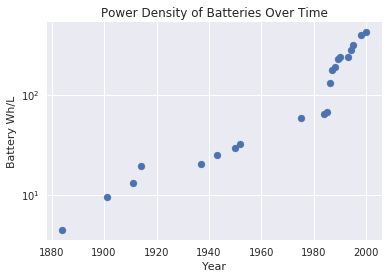

In [9]:
x = empirical_time_series['batteries_wh_lit_energy_density'].index
y = empirical_time_series['batteries_wh_lit_energy_density'].values
scatter(x,exp(y))
yscale('log')
ylabel("Battery Wh/L")
xlabel("Year")
title("Power Density of Batteries Over Time")

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  if __name__ == '__main__':
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


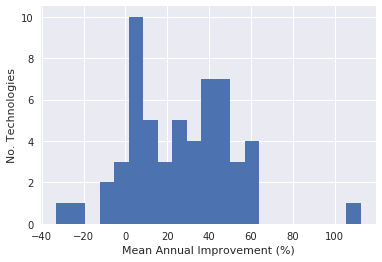

In [218]:
empirical_time_series_mean_change = empirical_time_series.loc[1976:].dropna(how='all',axis=1).apply(lambda x: (x.ix[x.last_valid_index()]-
                                                       x.ix[x.first_valid_index()])/(x.last_valid_index()-
                                                                                     x.first_valid_index()))

(empirical_time_series_mean_change*100).hist(bins=21)
ylabel("No. Technologies")
xlabel("Mean Annual Improvement (%)")

In [219]:
empirical_time_series_summary_stats = pd.DataFrame(columns=['Mean_Change'], data=empirical_time_series_mean_change)
empirical_time_series_summary_stats['Domain'] = metadata.set_index('Name').ix[empirical_time_series_summary_stats.index]['Domain']

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  from ipykernel import kernelapp as app


In [167]:
patent_data_directory = '/home/jeffrey_alstott/technoinnovation/patent_centralities/data/'

patents = pd.read_hdf(patent_data_directory+'patents.h5', 'df')
citations = pd.read_hdf(patent_data_directory+'citations.h5', 'df')

citations['Citation_Lag'] = citations['Year_Citing_Patent']-citations['Year_Cited_Patent']
backward_citations = citations.groupby('Citing_Patent')

patents['Citations_Backward_N'] = citations.groupby('Citing_Patent').size()[patents['patent_number']].values
patents['Citations_Backward_Age_Mean'] = citations.groupby('Citing_Patent')['Citation_Lag'].mean()[patents['patent_number']].values
patents['Citations_Backward_Age_STD'] = citations.groupby('Citing_Patent')['Citation_Lag'].std()[patents['patent_number']].values

patent_centralities_z = pd.read_hdf(patent_data_directory+'centralities/summary_statistics.h5', 'empirical_z_scores_USPC')
patent_centralities_z.drop('filing_year', axis=1, inplace=True)
patents = patents.merge(patent_centralities_z, on='patent_number')

patents_percentile_by_year = patents.copy()
for col in patents.columns:
    if col in ['filing_year', 'patent_number', 'Class']:
        continue
    patents_percentile_by_year[col] = patents.groupby('filing_year')[col].rank(pct=True)

In [18]:
# patent_data_directory = '/home/jeffrey_alstott/technoinnovation/patent_centralities/data/'

# patent_centralities_empirical = pd.read_hdf(patent_data_directory+'centralities/empirical.h5', 'df')
# patent_centralities_empirical.set_index('patent_number', inplace=True)

# patent_centralities_z = pd.read_hdf(patent_data_directory+'centralities/summary_statistics.h5', 'empirical_z_scores_USPC')
# patent_centralities_z.set_index('patent_number', inplace=True)

# patent_centralities_z_percentile_by_year = patent_centralities_z.copy()
# patent_centralities_empirical_percentile_by_year = patent_centralities_empirical.copy()
# for col in patent_centralities_z.columns:
#     if col=='filing_year':
#         continue
#     patent_centralities_z_percentile_by_year[col] = patent_centralities_z.groupby('filing_year')[col].rank(pct=True)
#     patent_centralities_empirical_percentile_by_year[col] = patent_centralities_empirical.groupby('filing_year')[col].rank(pct=True)

In [168]:
patents_percentile_by_year.set_index('patent_number', inplace=True)

In [169]:
patent_domains = pd.read_csv(data_directory+'PATENT_SET_DOMAINS.csv', index_col=0)
def floatify(x):
    from numpy import nan
    try:
        return float(x)
    except ValueError:
        return nan
patent_domains['patent_id'] = patent_domains['patent_id'].apply(floatify)
patent_domains = patent_domains.dropna()
domains = patent_domains['Domain'].unique() 
# domain_patent_count = patent_domains['Domain'].value_counts()
# empirical_time_series_summary_stats['Domain_Patent_Count'] = domain_patent_count.ix[empirical_time_series_summary_stats['Domain'].values].values

In [221]:
domain_means = patents_percentile_by_year.ix[patent_domains['patent_id'].values].groupby(patent_domains['Domain'].values).mean()
empirical_time_series_summary_stats = empirical_time_series_summary_stats.merge(domain_means, left_on='Domain', right_index=True)

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


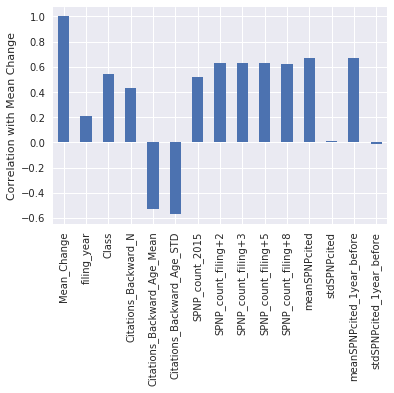

In [222]:
empirical_time_series_summary_stats.corr().loc['Mean_Change'].plot(kind='bar')
ylabel("Correlation with Mean Change")

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


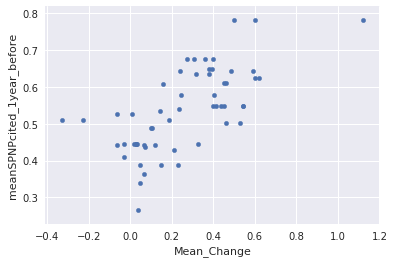

In [223]:
empirical_time_series_summary_stats.plot('Mean_Change', 'meanSPNPcited_1year_before', kind='scatter')

,empirical,z,percentile,z_percentile
SPNP_count_2015,0.534059,0.541329,0.417227,0.503402
SPNP_count_filing+2,0.620189,0.624192,0.635353,0.660276
SPNP_count_filing+3,0.623248,0.620266,0.629167,0.660323
SPNP_count_filing+5,0.629195,0.612994,0.608729,0.659075
SPNP_count_filing+8,0.655963,0.616917,0.577522,0.664797
meanSPNPcited,0.607892,0.662475,0.688765,0.708536
stdSPNPcited,0.145566,0.101314,0.385179,0.123871
meanSPNPcited_1year_before,0.605915,0.665966,0.692694,0.710522
stdSPNPcited_1year_before,0.139557,0.0858294,0.374917,0.104449


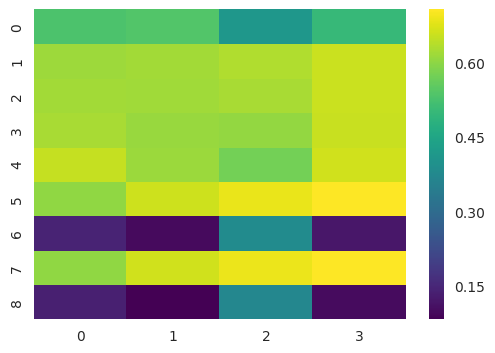

In [74]:
# targets = patent_centralities_z.columns
# targets = targets[targets!='filing_year']

# correlations = pd.DataFrame(columns=targets)

# fig = figure(figsize=(11,11))
# this_ax = 0
# for target in targets:
#     for df, name in [(empirical_patent_centralities, 'empirical'),
#                  (patent_centralities_z, 'z'),
#                  (patent_centralities_percentile, 'percentile'),
#                  (patent_centralities_z_percentile, 'z_percentile')
#                  ]:
#         this_ax +=1
#         ax = fig.add_subplot(len(targets), 4, this_ax)
#         domain_stat = df.ix[patent_domains['patent_id'].values, target].groupby(patent_domains['Domain'].values).mean()
#         empirical_time_series_summary_stats['%s_%s'%(target, name)] = domain_stat.ix[empirical_time_series_summary_stats['Domain'].values].values
#         empirical_time_series_summary_stats.plot('%s_%s'%(target, name), 'Mean_Change', kind='scatter', ax=ax)
#         r = empirical_time_series_summary_stats[['%s_%s'%(target, name), 'Mean_Change']].corr().iloc[1,0]
#         ax.set_title('%s_%s, R=%.2f'%(target, name, r))
#         correlations.ix[name, target] = r
        
#         sns.heatmap(correlations.T.values.astype('float'), cmap='viridis')
# correlations.T

In [81]:
# c = 'filing_year'    
# patent_domains[c] = empirical_patent_centralities.ix[patent_domains['patent_id'], c].values
# for c in ['meanSPNPcited_1year_before', 'stdSPNPcited_1year_before']:
#     patent_domains[c+'_empirical'] = empirical_patent_centralities.ix[patent_domains['patent_id'], c].values
#     patent_domains[c+'_percentile'] = patent_centralities_percentile.ix[patent_domains['patent_id'], c].values
#     patent_domains[c+'_z'] = patent_centralities_z.ix[patent_domains['patent_id'], c].values
#     patent_domains[c+'_z_percentile'] = patent_centralities_z_percentile.ix[patent_domains['patent_id'], c].values

In [184]:

c = 'filing_year'    
patent_domains[c] = patents_percentile_by_year.ix[patent_domains['patent_id'], c].values
for c in ['meanSPNPcited_1year_before', 'Citations_Backward_Age_Mean', 'Citations_Backward_Age_STD']:
    patent_domains[c] = patents_percentile_by_year.ix[patent_domains['patent_id'], c].values

In [185]:
g = patent_domains.groupby(['Domain', 'filing_year']).mean()
g = g.reindex([(d,y) for d in valid_domains for y in arange(1976, 2015)])

In [83]:
# for domain in valid_domains:
#     print(domain)
#     print(g.ix[domain].drop('patent_id', axis=1).reindex(arange(1976,2010))['meanSPNPcited_1year_before_empirical'].isnull().sum())  

In [189]:
average_variability = g.drop('patent_id', axis=1).groupby(level='Domain').apply(lambda x: x.diff().mean())
for col in average_variability:
    empirical_time_series_summary_stats[col+'_average_variability'] = average_variability.ix[empirical_time_series_summary_stats['Domain'].values,
                                                                                             col
                                                                                            ].values
    
average_percent_variability = g.drop('patent_id', axis=1).groupby(level='Domain').apply(lambda x: (x.diff()/x).mean())
for col in average_percent_variability:
    empirical_time_series_summary_stats[col+'_average_percent_variability'] = average_percent_variability.ix[empirical_time_series_summary_stats['Domain'].values,
                                                                                             col
                                                                                            ].values

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  app.launch_new_instance()
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


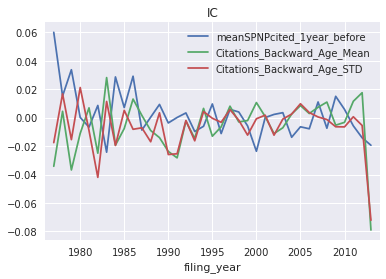

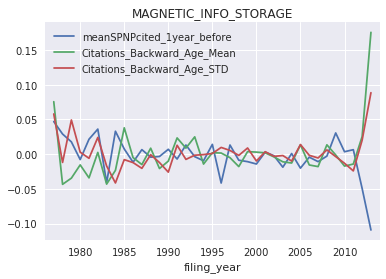

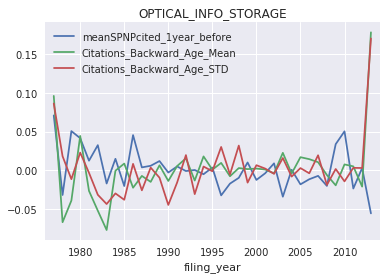

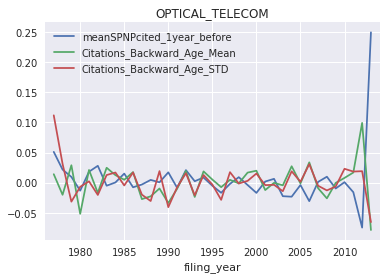

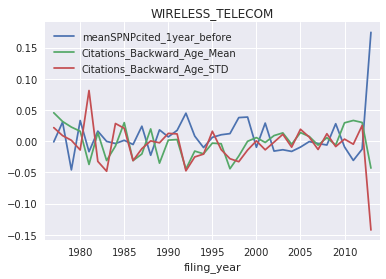

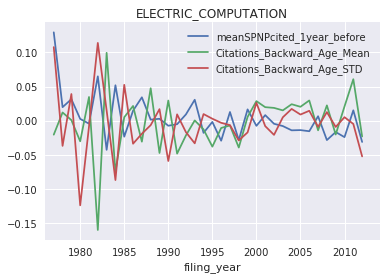

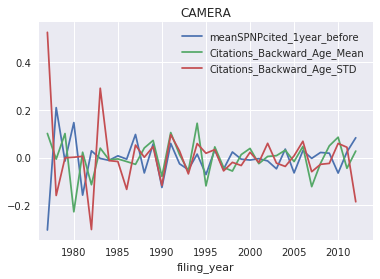

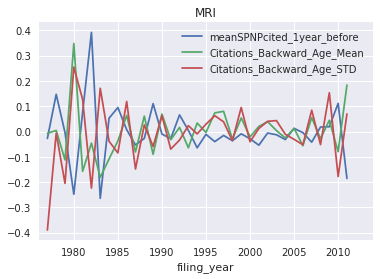

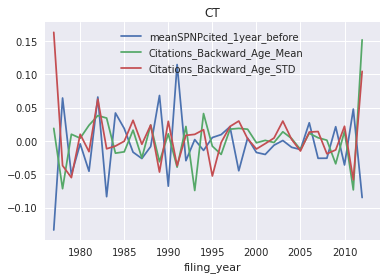

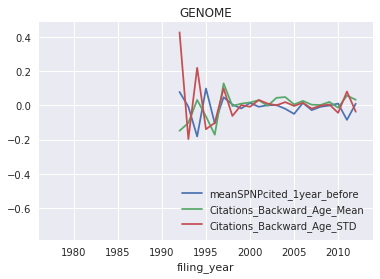

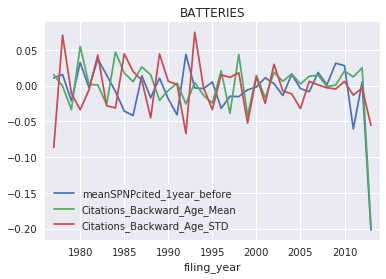

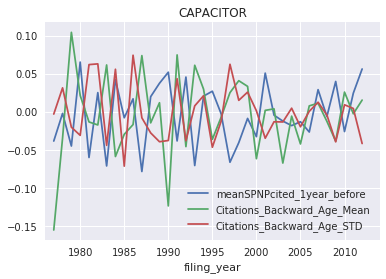

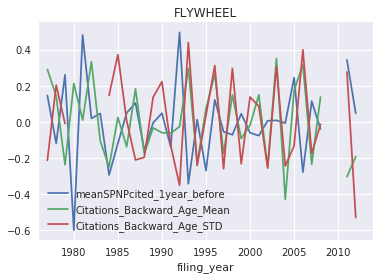

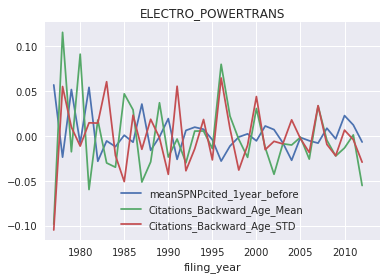

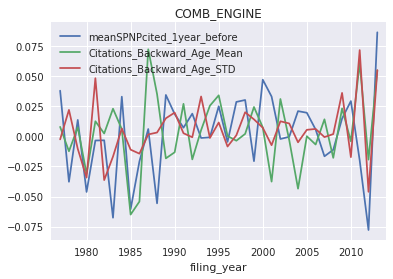

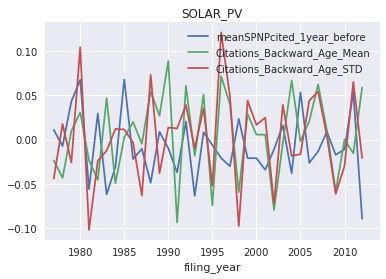

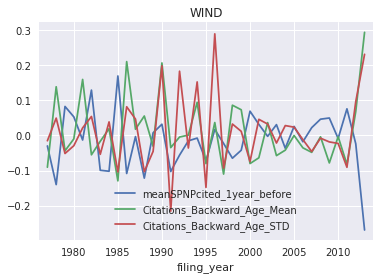

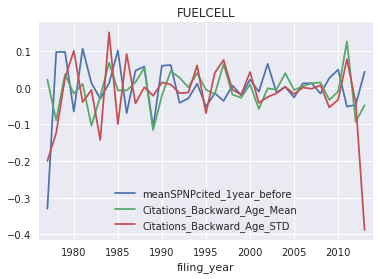

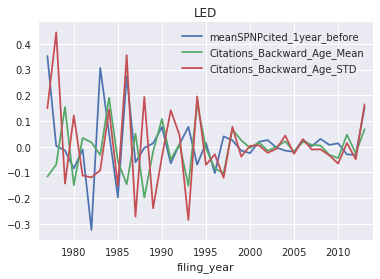

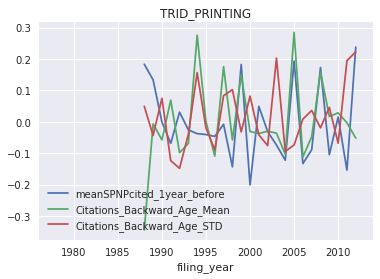

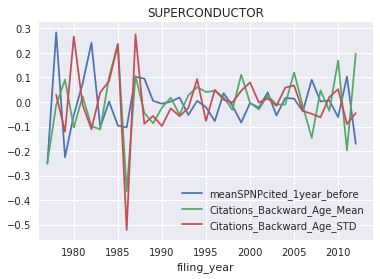

In [192]:
for domain in valid_domains:
    figure()
    g.loc[domain].drop('patent_id', axis=1).diff().plot()
    title(domain)

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


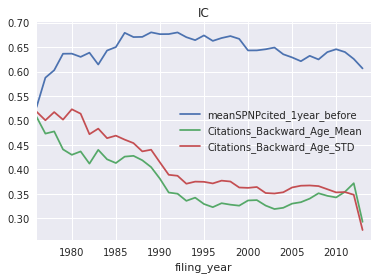

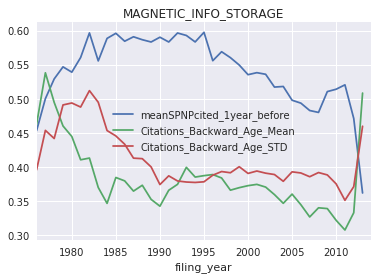

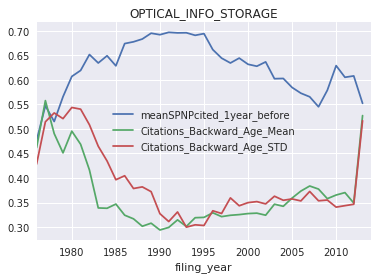

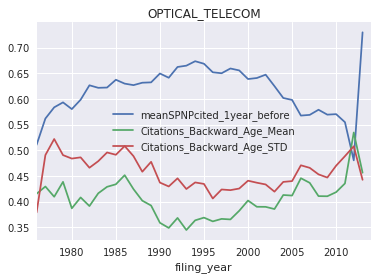

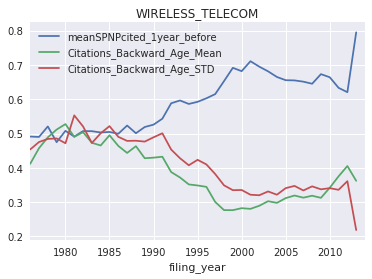

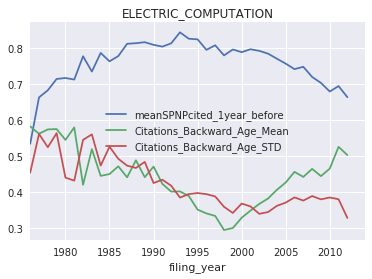

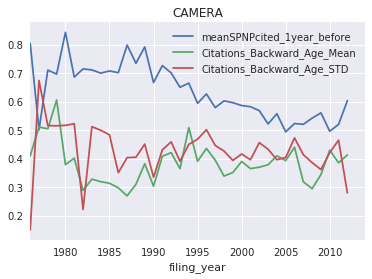

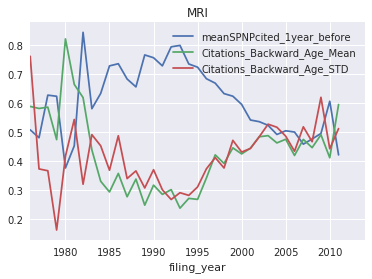

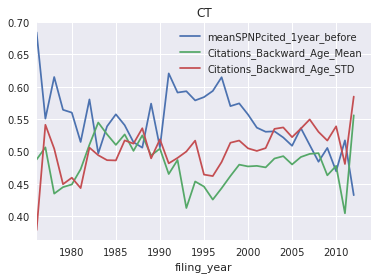

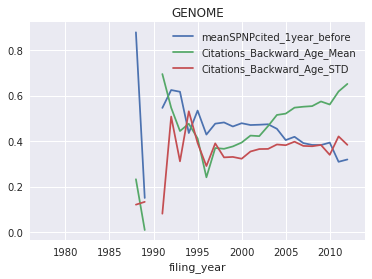

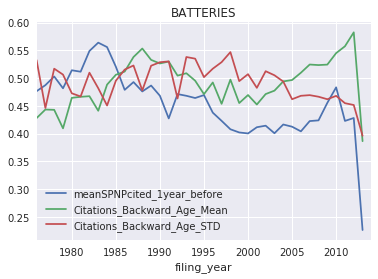

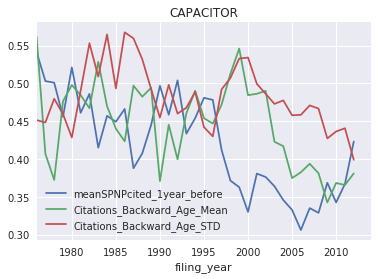

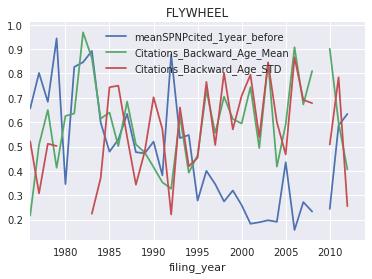

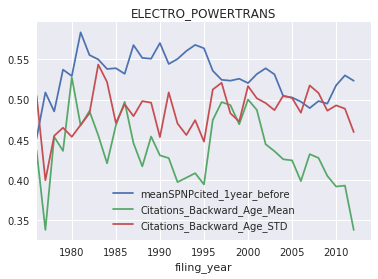

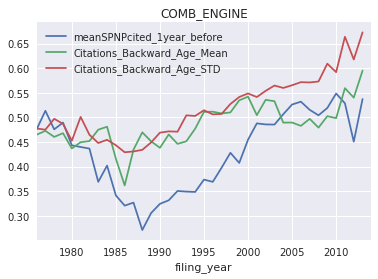

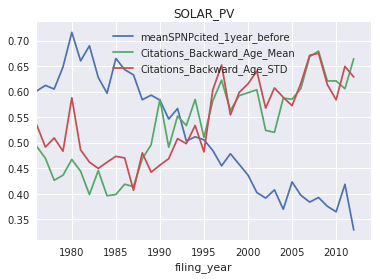

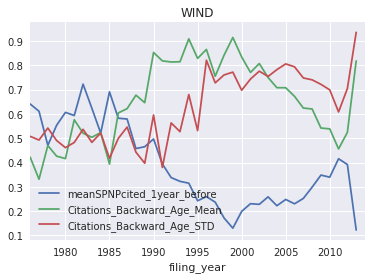

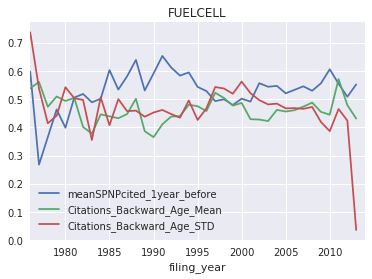

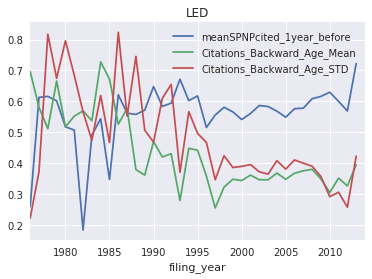

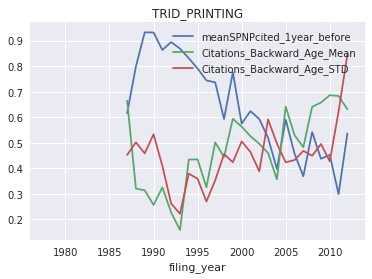

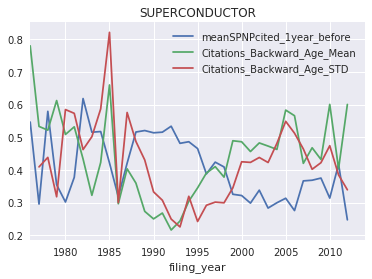

In [193]:
for domain in valid_domains:
    figure()
    g.loc[domain].drop('patent_id', axis=1).plot()
    title(domain)

In [85]:
from pystan.misc import _summary, _array_to_table
def _print_stanfit(fit, pars=None, probs=(0.025, 0.25, 0.5, 0.75, 0.975), digits_summary=2):
        if fit.mode == 1:
            return "Stan model '{}' is of mode 'test_grad';\n"\
                   "sampling is not conducted.".format(fit.model_name)
        elif fit.mode == 2:
            return "Stan model '{}' does not contain samples.".format(fit.model_name)
        if pars is None:
            pars = fit.sim['pars_oi']
            fnames = fit.sim['fnames_oi']

        n_kept = [s - w for s, w in zip(fit.sim['n_save'], fit.sim['warmup2'])]
        header = ""#Inference for Stan model: {}.\n".format(fit.model_name)
        header += "{} chains, each with iter={}; warmup={}; thin={}; \n"
        header = header.format(fit.sim['chains'], fit.sim['iter'], fit.sim['warmup'],
                               fit.sim['thin'], sum(n_kept))
        header += "post-warmup draws per chain={}, total post-warmup draws={}.\n\n"
        header = header.format(n_kept[0], sum(n_kept))
        footer = "\n\nSamples were drawn using {} at {}.\n"\
#             "For each parameter, n_eff is a crude measure of effective sample size,\n"\
#             "and Rhat is the potential scale reduction factor on split chains (at \n"\
#             "convergence, Rhat=1)."
        sampler = fit.sim['samples'][0]['args']['sampler_t']
        date = fit.date.strftime('%c')  # %c is locale's representation
        footer = footer.format(sampler, date)
        s = _summary(fit, pars, probs)
        body = _array_to_table(s['summary'], s['summary_rownames'],
                               s['summary_colnames'], digits_summary)
        return header + body + footer
    
def plot_time_series_inference(model_fit, var='Y_sim', x=None,
                               ax=None, ind=0, **kwargs):
    from scipy.stats import scoreatpercentile
    ci_thresholds = [2.5, 25, 75, 97.5]
    if len(model_fit[var].shape)<3:
        data = model_fit[var]
    else:
        data = model_fit[var][:,:,ind]
    CIs = scoreatpercentile(data, ci_thresholds, axis=0)
    CIs = pd.DataFrame(data=CIs.T, columns=ci_thresholds)
    if ax is None:
        ax=gca()
    if x is None:
        x = arange(data.shape[1])
    ax.fill_between(x, CIs[2.5], CIs[97.5],alpha=.5, **kwargs)
    ax.fill_between(x, CIs[25], CIs[75], **kwargs)
    
from scipy.stats import percentileofscore
def portion_of_data_within_CI(model_fit, parameter, data, lower=2.5, upper=97.5):
    if data.ndim<2:
        a = array((list(map(percentileofscore, model_fit[parameter].T, data))))
        return mean((lower<a)*(a<upper))
    else:
        values = empty(data.shape[1])
        for i in range(data.shape[1]):
            a = array((list(map(percentileofscore, model_fit[parameter][:,i], data.iloc[:,i]))))
            values[i]=nanmean((lower<a)*(a<upper))
        return values
    
def portion_of_forecast_within_CI(model_fit, forecast, data, 
                                  forecast_start_ind, forecast_stop_ind,
                                  lower=2.5, upper=97.5):
    u = percentile(model_fit[forecast],upper,axis=0)
    l = percentile(model_fit[forecast],lower,axis=0)
    return nanmean((l[forecast_start_ind:forecast_stop_ind]<data[forecast_start_ind:forecast_stop_ind])*
                   (data[forecast_start_ind:forecast_stop_ind]<u[forecast_start_ind:forecast_stop_ind]),
                  axis=0)

def calculate_Omega_from_L_Omega(model_fit):
    f = lambda x,y: matrix(x)*matrix(y)
    return list(map(f, model_fit['L_Omega'], transpose(model_fit['L_Omega'],[0,2,1])))

def calculate_covariance_from_L_Omega_and_tau(model_fit):
    Omegas = calculate_Omega_from_L_Omega(model_fit)
    f = lambda tau, Omega: diag(tau)*Omega*diag(tau)
    return list(map(f, model_fit['tau'], Omegas))

In [86]:
def stan_data_from_Y(Y,
                     backcast_to_observation=1,
                    forecast_to_observation=None,
                    predictors=None):
    Y = Y.copy()
    Y.index = arange(Y.shape[0])
    Y.columns = arange(Y.shape[1])
    N_time_periods, N_technologies = Y.shape
    first_observation = Y.apply(lambda x: x.first_valid_index())
    last_observation = Y.apply(lambda x: x.last_valid_index())
    first_observation_value = Y.apply(lambda x: x[x.first_valid_index()])

    if forecast_to_observation is None:
        forecast_to_observation = Y.shape[0]+1
        
    N_updates = sum(last_observation-first_observation)
    
    updates_vector = []
    tech_starts = []
    tech_stops = []
    updates_tech_inds = []
    for i in Y.columns:
        tech_starts.append(len(updates_vector))
        this_updates = Y.ix[first_observation[i]:last_observation[i],i].diff()[1:].values.tolist()
        updates_vector += this_updates
        tech_stops.append(len(updates_vector))
        updates_tech_inds+=[i for j in this_updates]
    updates_vector = pd.Series(updates_vector)
    N_updates = len(updates_vector)

    N_gap_updates = {}
    gap_starts = {}
    gap_stops = {}
    gap_lengths = {}
    gap_heights = {}
    gap_time_steps = {}
    gap_techs = {}
    for i in Y.columns:
        gap_inds = Y.ix[first_observation[i]:last_observation[i],i].isnull().astype('int')
        d = gap_inds.diff()
        gap_starts[i] = d[d==1].index.values.astype('int')
        gap_stops[i] = d[d==-1].index.values.astype('int')
        gap_lengths[i] = gap_stops[i]-gap_starts[i]
        N_gap_updates[i] = gap_lengths[i]+1
        gap_heights[i] = Y.ix[gap_stops[i],i].values - Y.ix[gap_starts[i]-1,i].values
        gap_time_steps[i] = gap_inds[gap_inds==1].index.values

    gap_heights_vector = []
    gap_lengths_vector = []
    for i in Y.columns:
        gap_heights_vector+=gap_heights[i].tolist()
        gap_lengths_vector+=gap_lengths[i].tolist()

    stan_data = {'N_technologies': N_technologies,
                 'N_updates': N_updates,
                 'observed_updates': updates_vector.fillna(-999.0),
                 'updates_tech_inds': array(updates_tech_inds).astype('int')+1,
                 'tech_starts': array(tech_starts).astype('int')+1,
                 'tech_stops': array(tech_stops).astype('int'),
                 'N_gaps': len(gap_heights_vector),
                 'gap_heights': gap_heights_vector,
                 'gap_lengths': array(gap_lengths_vector).astype('int'),
                 'N_gap_updates': sum([sum(N_gap_updates[i]) for i in N_gap_updates]),
                'first_observation_value': first_observation_value,                 
                'first_observation': first_observation.astype('int')+1,
                'last_observation': last_observation.astype('int')+1,
                'backcast_to_observation': backcast_to_observation,
                'forecast_to_observation': forecast_to_observation,
#                  'n_predictors': predictors.shape[1]
#                 'predictors': predictors
                }
    
    return stan_data

In [87]:
import pickle
models = pickle.load(open('model.pkl', 'rb'))

In [88]:
technology_models_fit_parameters = {}

In [96]:
def fit_with_model(model_name,
                   model_code=None, 
                   model_parameters=None,
                   parameter_priors=None, 
                   time_series=empirical_time_series,
                   technology_models_fit_parameters=technology_models_fit_parameters,
                   print_output=True):
    
    if model_code is None:
        model_code = models[model_name]['code']
    if model_parameters is None:
        model_parameters = models[model_name]['model_parameters']
    if parameter_priors is None:
        parameter_priors = models[model_name]['parameter_priors']
    
    technology_models_fit_parameters[model_name] = pd.DataFrame(index=model_parameters, 
                                                                columns=time_series.columns
                                                                )

    stan_data = stan_data_from_Y(time_series)
    stan_data = {**stan_data, **parameter_priors} 

    ###
    model_fit = models[model_name]['stan_model'].sampling(data=stan_data, n_jobs=n_jobs)

    if print_output:
        print(_print_stanfit(model_fit, model_parameters))
    for parameter in model_parameters:
        technology_models_fit_parameters[model_name].ix[parameter] = model_fit[parameter].mean(axis=0)

In [97]:
model_name = 'improvement~N(mu,sigma)'#, hierarchical'
target_tech_names = metadata.ix[(metadata['Type']=='Performance')*(~metadata['Domain'].isnull()), 'Name']
target_tech_time_series = empirical_time_series.ix[1976:, target_tech_names]
target_tech_names = (~target_tech_time_series.isnull()).sum()>2
target_tech_names = target_tech_names.ix[target_tech_names.values].index
target_tech_time_series = empirical_time_series.ix[1976:, target_tech_names]
fit_with_model(model_name, time_series=target_tech_time_series)

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]       0.23  2.7e-3   0.11   0.02   0.14   0.24   0.32   0.42   1708    1.0
mu[1]       0.14  1.8e-3    0.1 6.2e-3   0.06   0.13   0.21   0.36   2867    1.0
mu[2]        0.2  2.7e-3   0.13 6.0e-3   0.08   0.18   0.29   0.47   2349    1.0
mu[3]       0.18  2.3e-3   0.12 7.8e-3   0.08   0.17   0.27   0.43   2527    1.0
mu[4]       0.16  2.1e-3   0.11 6.7e-3   0.06   0.14   0.23    0.4   2833    1.0
mu[5]       0.17  2.1e-3   0.09   0.01   0.09   0.17   0.24   0.34   2008    1.0
mu[6]       0.31  3.9e-3    0.2   0.02   0.14   0.29   0.46   0.73   2721    1.0
mu[7]       0.12  1.9e-3   0.12 3.3e-3   0.04   0.08   0.17   0.43   4000    1.0
mu[8]       0.05  6.9e-4   0.04 1.2e-3   0.01   0.03   0.07   0.16   4000    1.0
mu[9]       0.09  1.3e-3   0.08 2.5e-3   0.03   0.07   0.14   0.31   400

In [98]:
model_name = 'improvement~logN(mu,sigma)'#, hierarchical'
target_tech_names = metadata.ix[(metadata['Type']=='Performance')*(~metadata['Domain'].isnull()), 'Name']
target_tech_time_series = empirical_time_series.ix[1976:, target_tech_names]
target_tech_names = (~target_tech_time_series.isnull()).sum()>2
target_tech_names = target_tech_names.ix[target_tech_names.values].index
target_tech_time_series = empirical_time_series.ix[1976:, target_tech_names]
fit_with_model(model_name, time_series=target_tech_time_series)

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      -1.13  1.9e-3   0.12  -1.38   -1.2  -1.13  -1.06   -0.9   4000    1.0
mu[1]      -1.22  2.7e-3   0.17  -1.56  -1.33  -1.21   -1.1  -0.89   4000    1.0
mu[2]      -1.26  4.8e-3    0.3  -1.87  -1.45  -1.25  -1.06  -0.69   4000    1.0
mu[3]      -1.23  4.2e-3   0.27  -1.74   -1.4  -1.23  -1.06   -0.7   4000    1.0
mu[4]      -1.31  4.8e-3    0.3  -1.88  -1.51  -1.32  -1.12  -0.69   4000    1.0
mu[5]      -1.39  3.1e-3    0.2  -1.79  -1.51  -1.38  -1.26  -1.01   4000    1.0
mu[6]      -0.95  6.1e-3   0.39  -1.73   -1.2  -0.94   -0.7   -0.2   4000    1.0
mu[7]      -2.62  7.3e-3   0.46  -3.49  -2.93  -2.63  -2.32  -1.69   4000    1.0
mu[8]      -2.28  4.9e-3   0.31   -2.9  -2.49  -2.28  -2.08  -1.66   4000    1.0
mu[9]      -1.51  3.9e-3   0.25  -2.01  -1.66   -1.5  -1.34  -1.02   400

In [99]:
model_name = 'price~N(mu,sigma)'#, hierarchical'
target_tech_names = metadata.ix[(metadata['Type']=='Price')*(~metadata['Domain'].isnull()), 'Name']
target_tech_time_series = empirical_time_series.ix[1976:, target_tech_names]
target_tech_names = (~target_tech_time_series.isnull()).sum()>2
target_tech_names = target_tech_names.ix[target_tech_names.values].index
target_tech_time_series = empirical_time_series.ix[1976:, target_tech_names]
fit_with_model(model_name, time_series=target_tech_time_series)

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]       0.53  5.8e-3   0.22    0.1   0.39   0.54   0.67   0.97   1447    1.0
mu[1]       0.44  5.3e-3   0.18   0.08   0.33   0.44   0.56   0.77   1106    1.0
mu[2]       0.54  4.9e-3   0.15   0.24   0.44   0.54   0.63   0.82    870    1.0
mu[3]       0.38    0.02   0.33  -0.28    0.2   0.37   0.55   1.06    455   1.01
mu[4]        0.6  7.2e-3   0.26   0.09   0.43    0.6   0.77   1.11   1333    1.0
mu[5]        0.6    0.01   0.36   -0.1   0.36   0.59   0.83   1.34   1328    1.0
mu[6]       0.46  2.8e-3    0.1   0.27    0.4   0.46   0.53   0.67   1318    1.0
mu[7]       0.33  1.9e-3   0.06    0.2   0.28   0.33   0.37   0.45   1095    1.0
mu[8]      -0.06  4.4e-3   0.17   -0.4  -0.17  -0.06   0.04   0.26   1406    1.0
mu[9]       0.23  2.8e-3   0.09   0.06   0.17   0.23   0.29   0.41   110

In [100]:
dist_entropy = lambda df: norm(loc=df['mu'], scale=df['sigma']).entropy()
x = technology_models_fit_parameters['price~N(mu,sigma)'].apply(dist_entropy)
technology_models_fit_parameters['price~N(mu,sigma)'].ix['entropy']  = x

dist_entropy = lambda df: truncnorm(0, 10000, loc=df['mu'], scale=df['sigma']).entropy()
x = technology_models_fit_parameters['improvement~N(mu,sigma)'].apply(dist_entropy)
technology_models_fit_parameters['improvement~N(mu,sigma)'].ix['entropy']  = x

dist_entropy = lambda df: lognorm(df['sigma'], scale=exp(df['mu']), loc=0).entropy()
x = technology_models_fit_parameters['improvement~logN(mu,sigma)'].apply(dist_entropy)
technology_models_fit_parameters['improvement~logN(mu,sigma)'].ix['entropy']  = x

In [ ]:

    xlabel(independent)
    ylabel("Inferred Annual Improvement %s"%dependent)
    title()

    figure()
    model = 'improvement~logN(mu,sigma)'
    y = technology_models_fit_parameters[model].ix[dependent]
    x = empirical_time_series_summary_stats.ix[y.index, independent]
    y = y[~x.isnull()]
    x = x[~x.isnull()]
    scatter(x,y)
    xlabel(independent)
    ylabel("Inferred Annual Improvement %s"%dependent)
    title("%s, R=%.2f"%(model, pearsonr(x,y)[0]))
    
    figure()
    model = 'price~N(mu,sigma)'
    y = technology_models_fit_parameters[model].ix[dependent]
    x = empirical_time_series_summary_stats.ix[y.index, independent]
    y = y[~x.isnull()]
    x = x[~x.isnull()]
    scatter(x,y)

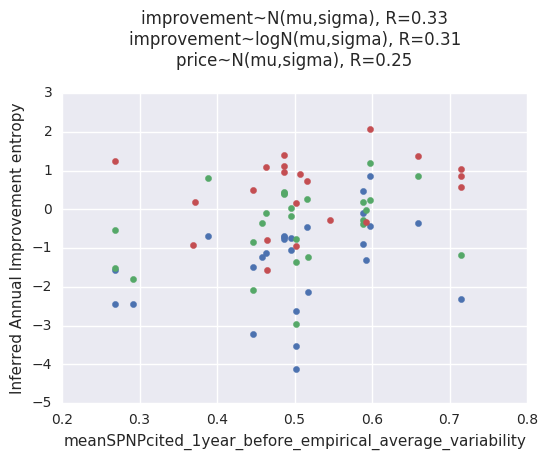

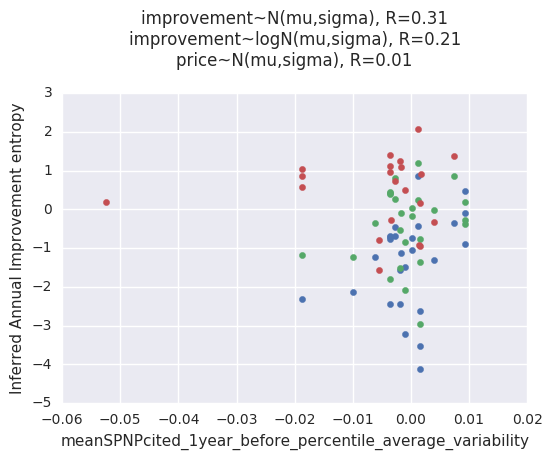

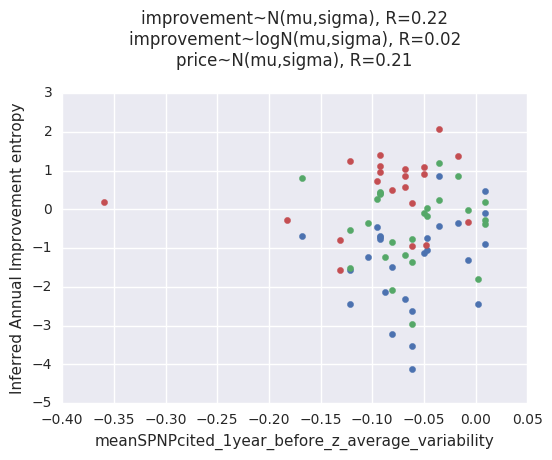

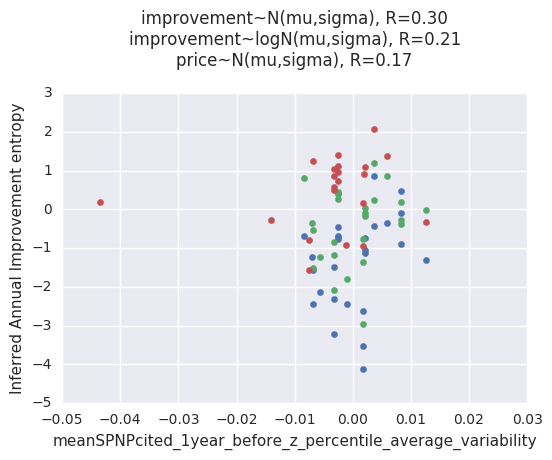

In [108]:
from scipy.stats import pearsonr

for col in average_variability:
    if col.startswith('std'):
        continue
    independent = col+'_average_variability'
    # independent = 'meanSPNPcited_1year_before_percentile'
    dependent = 'entropy'
    
    figure()
    title_string = ""
    
    model = 'improvement~N(mu,sigma)'
    y = technology_models_fit_parameters[model].ix[dependent]
    x = empirical_time_series_summary_stats.ix[y.index, independent]
    y = y[~x.isnull()]
    x = x[~x.isnull()]
    scatter(x,y, color='b')
    title_string = title_string+"%s, R=%.2f\n"%(model, pearsonr(x,y)[0])
    
    model = 'improvement~logN(mu,sigma)'
    y = technology_models_fit_parameters[model].ix[dependent]
    x = empirical_time_series_summary_stats.ix[y.index, independent]
    y = y[~x.isnull()]
    x = x[~x.isnull()]
    scatter(x,y, color='g')
    title_string = title_string+"%s, R=%.2f\n"%(model, pearsonr(x,y)[0])
    
    model = 'price~N(mu,sigma)'
    y = technology_models_fit_parameters[model].ix[dependent]
    x = empirical_time_series_summary_stats.ix[y.index, independent]
    y = y[~x.isnull()]
    x = x[~x.isnull()]
    scatter(x,y, color='r')
    title_string = title_string+"%s, R=%.2f\n"%(model, pearsonr(x,y)[0])
    
    title(title_string)
    
    xlabel(independent)
    ylabel("Inferred Annual Improvement %s"%dependent)

In [123]:
def stan_data_from_Y(Y,
                     backcast_to_observation=1,
                    forecast_to_observation=None,
                    predictors=None):
    Y = Y.copy()
    Y.index = arange(Y.shape[0])
    Y.columns = arange(Y.shape[1])
    N_time_periods, N_technologies = Y.shape
    first_observation = Y.apply(lambda x: x.first_valid_index())
    last_observation = Y.apply(lambda x: x.last_valid_index())
    first_observation_value = Y.apply(lambda x: x[x.first_valid_index()])

    if forecast_to_observation is None:
        forecast_to_observation = Y.shape[0]+1
        
    N_updates = sum(last_observation-first_observation)
    
    updates_vector = []
    tech_starts = []
    tech_stops = []
    updates_tech_inds = []
    for i in Y.columns:
        tech_starts.append(len(updates_vector))
        this_updates = Y.ix[first_observation[i]:last_observation[i],i].diff()[1:].values.tolist()
        updates_vector += this_updates
        tech_stops.append(len(updates_vector))
        updates_tech_inds+=[i for j in this_updates]
    updates_vector = pd.Series(updates_vector)
    N_updates = len(updates_vector)

    N_gap_updates = {}
    gap_starts = {}
    gap_stops = {}
    gap_lengths = {}
    gap_heights = {}
    gap_time_steps = {}
    gap_techs = {}
    for i in Y.columns:
        gap_inds = Y.ix[first_observation[i]:last_observation[i],i].isnull().astype('int')
        d = gap_inds.diff()
        gap_starts[i] = d[d==1].index.values.astype('int')
        gap_stops[i] = d[d==-1].index.values.astype('int')
        gap_lengths[i] = gap_stops[i]-gap_starts[i]
        N_gap_updates[i] = gap_lengths[i]+1
        gap_heights[i] = Y.ix[gap_stops[i],i].values - Y.ix[gap_starts[i]-1,i].values
        gap_time_steps[i] = gap_inds[gap_inds==1].index.values

    gap_heights_vector = []
    gap_lengths_vector = []
    for i in Y.columns:
        gap_heights_vector+=gap_heights[i].tolist()
        gap_lengths_vector+=gap_lengths[i].tolist()

    stan_data = {'N_technologies': N_technologies,
                 'N_updates': N_updates,
                 'observed_updates': updates_vector.fillna(-999.0),
                 'updates_tech_inds': array(updates_tech_inds).astype('int')+1,
                 'tech_starts': array(tech_starts).astype('int')+1,
                 'tech_stops': array(tech_stops).astype('int'),
                 'N_gaps': len(gap_heights_vector),
                 'gap_heights': gap_heights_vector,
                 'gap_lengths': array(gap_lengths_vector).astype('int'),
                 'N_gap_updates': sum([sum(N_gap_updates[i]) for i in N_gap_updates]),
                'first_observation_value': first_observation_value,                 
                'first_observation': first_observation.astype('int')+1,
                'last_observation': last_observation.astype('int')+1,
                'backcast_to_observation': backcast_to_observation,
                'forecast_to_observation': forecast_to_observation,
                }
    if predictors is not None:
        predictors.index = arange(Y.shape[0])
        predictors.columns = arange(Y.shape[1])
        predictors_vector = []
        for i in Y.columns:
            predictors_vector += predictors.ix[first_observation[i]:last_observation[i],i][1:].values.tolist()
        stan_data = {**stan_data, 
                     **{'N_predictors': 1,
                       'predictors': predictors_vector}
                    } 
    return stan_data

In [115]:
model_name = 'improvement~N(mu+beta,sigma)'
models[model_name] = {}
models[model_name]['code']  = """
functions{
    
    real lower_truncated_normal_lpdf_vector(vector x, vector mu, vector sigma, real A) {
            return(normal_lpdf(x | mu, sigma) - normal_lccdf(A | mu, sigma));
    }

}

data {
    int N_technologies;
    int N_updates;
    vector[N_updates] observed_updates;
    int updates_tech_inds[N_updates];
    
    int tech_starts[N_technologies];
    int tech_stops[N_technologies];
    
    real first_observation_value[N_technologies];
    int first_observation[N_technologies];
    int last_observation[N_technologies];  
    int backcast_to_observation;
    int forecast_to_observation;
    
    
    int N_gaps;
    real gap_heights[N_gaps];
    int gap_lengths[N_gaps];
    
    int N_gap_updates;

    int N_predictors;
    vector[N_updates] predictors;
    
    real mu_prior_location;
    real mu_prior_scale;

    real sigma_prior_location;
    real sigma_prior_scale;
    
    real beta_prior_location;
    real beta_prior_scale;

}

  
parameters {
    vector<lower = 0, upper = 1>[N_gap_updates] gap_updates_raw; // inferred updates between first and last observations

    
    vector<lower = 0>[N_technologies] mu;
    vector<lower = 0>[N_technologies] sigma;
    vector<lower = 0>[N_technologies] beta;
    
}

transformed parameters {
    //vector[N_time_steps_to_fit] Y_latent; // value each time period
    vector<lower = 0>[N_gap_updates] gap_updates;
    vector<lower = 0>[N_updates] updates;
    
    {
    int latest_gap_position;
    latest_gap_position = 1;
    for(i in 1:N_gaps){
        gap_updates[latest_gap_position:latest_gap_position+gap_lengths[i]] = 
        gap_updates_raw[latest_gap_position:latest_gap_position+gap_lengths[i]]/
        sum(gap_updates_raw[latest_gap_position:latest_gap_position+gap_lengths[i]]) 
        * gap_heights[i];
        latest_gap_position = latest_gap_position + gap_lengths[i] + 1;
    }
    }
    
    {
    int gap_ind;
    gap_ind = 1;
    for (u in 1:N_updates){
        if (observed_updates[u]!=-999.0){
            updates[u] = observed_updates[u];
        }
        else{
            updates[u] = gap_updates[gap_ind];
            gap_ind = gap_ind + 1;
        }
        
    }
    }
}

model {
    
    mu ~ normal(mu_prior_location, mu_prior_scale);
    sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    beta ~ normal(beta_prior_location, beta_prior_scale);

    target += lower_truncated_normal_lpdf_vector(updates, 
                                                mu[updates_tech_inds]+(beta[updates_tech_inds].*predictors), 
                                                sigma[updates_tech_inds], 0.0);

}
"""

models[model_name]['model_parameters'] = ['mu', 'sigma', 'beta']
models[model_name]['parameter_priors'] = {
    'mu_prior_location': 0,
    'mu_prior_scale': 1,
    'sigma_prior_location': 0,
    'sigma_prior_scale': 2,
    'beta_prior_location': 0,
    'beta_prior_scale': 1,    
    }

models[model_name]['stan_model'] = StanModel(model_code=models[model_name]['code'])

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3bc4b8acb2656f874939c709fb562313 NOW.


In [116]:
model_name = 'price~N(mu+beta,sigma)'
models[model_name] = {}
models[model_name]['code']  = """

functions{
    

}

data {
    int N_technologies;
    int N_updates;
    vector[N_updates] observed_updates;
    int updates_tech_inds[N_updates];
    
    int tech_starts[N_technologies];
    int tech_stops[N_technologies];
    
    real first_observation_value[N_technologies];
    int first_observation[N_technologies];
    int last_observation[N_technologies];  
    int backcast_to_observation;
    int forecast_to_observation;
    
    
    int N_gaps;
    real gap_heights[N_gaps];
    int gap_lengths[N_gaps];
    
    int N_gap_updates;

    vector[N_updates] predictors;
    
    real mu_prior_location;
    real mu_prior_scale;

    real sigma_prior_location;
    real sigma_prior_scale;
    
    real beta_prior_location;
    real beta_prior_scale;

}

  
parameters {
    vector<lower = -1, upper = 1>[N_gap_updates] gap_updates_raw; // inferred updates between first and last observations

    
    vector[N_technologies] mu;
    vector<lower = 0>[N_technologies] sigma;
    vector[N_technologies] beta;

    
}

transformed parameters {
    //vector[N_time_steps_to_fit] Y_latent; // value each time period
    vector[N_gap_updates] gap_updates;
    vector[N_updates] updates;
    
    {
    int latest_gap_position;
    latest_gap_position = 1;
    for(i in 1:N_gaps){
        gap_updates[latest_gap_position:latest_gap_position+gap_lengths[i]] = 
        gap_updates_raw[latest_gap_position:latest_gap_position+gap_lengths[i]]/
        sum(gap_updates_raw[latest_gap_position:latest_gap_position+gap_lengths[i]]) 
        * gap_heights[i];
        latest_gap_position = latest_gap_position + gap_lengths[i] + 1;
    }
    }
    
    {
    int gap_ind;
    gap_ind = 1;
    for (u in 1:N_updates){
        if (observed_updates[u]!=-999.0){
            updates[u] = observed_updates[u];
        }
        else{
            updates[u] = gap_updates[gap_ind];
            gap_ind = gap_ind + 1;
        }
        
    }
    }
}

model {
    
    mu ~ normal(mu_prior_location, mu_prior_scale);
    sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    beta ~ normal(beta_prior_location, beta_prior_scale);

    target += normal_lpdf(updates | mu[updates_tech_inds]+beta[updates_tech_inds].*predictors, sigma[updates_tech_inds]);

}
"""

models[model_name]['model_parameters'] = ['mu', 'sigma', 'beta']
models[model_name]['parameter_priors'] = {
    'mu_prior_location': 0,
    'mu_prior_scale': 1,
    'sigma_prior_location': 0,
    'sigma_prior_scale': 2,
    'beta_prior_location': 0,
    'beta_prior_scale': 1,    
    }

models[model_name]['stan_model'] = StanModel(model_code=models[model_name]['code'])

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_994e1d0c4d5f56a9426888e745539172 NOW.


In [117]:
def fit_with_model(model_name,
                   model_code=None, 
                   model_parameters=None,
                   parameter_priors=None, 
                   time_series=empirical_time_series,
                   technology_models_fit_parameters=technology_models_fit_parameters,
                   print_output=True,
                  predictors=None):
    
    if model_code is None:
        model_code = models[model_name]['code']
    if model_parameters is None:
        model_parameters = models[model_name]['model_parameters']
    if parameter_priors is None:
        parameter_priors = models[model_name]['parameter_priors']
    
    technology_models_fit_parameters[model_name] = pd.DataFrame(index=model_parameters, 
                                                                columns=time_series.columns
                                                                )

    stan_data = stan_data_from_Y(time_series, predictors=predictors)
    stan_data = {**stan_data, **parameter_priors} 

    ###
    model_fit = models[model_name]['stan_model'].sampling(data=stan_data, n_jobs=n_jobs)

    if print_output:
        print(_print_stanfit(model_fit, model_parameters))
    for parameter in model_parameters:
        technology_models_fit_parameters[model_name].ix[parameter] = model_fit[parameter].mean(axis=0)

In [124]:
model_name = 'improvement~N(mu+beta,sigma)'#, hierarchical'
target_tech_names = metadata.ix[(metadata['Type']=='Performance')*(~metadata['Domain'].isnull()), 'Name']
target_tech_time_series = empirical_time_series.ix[1976:, target_tech_names]
target_tech_names = (~target_tech_time_series.isnull()).sum()>3
target_tech_names = target_tech_names.ix[target_tech_names.values].index
target_tech_time_series = empirical_time_series.ix[1976:, target_tech_names]

predictor = 'meanSPNPcited_1year_before_z_percentile'
predictors = target_tech_time_series.copy()
for col in predictors.columns:
    predictors[col] = g.ix[metadata.set_index('Name').ix[col, 'Domain']][predictor]
predictors.fillna(0, inplace=True)

fit_with_model(model_name, time_series=target_tech_time_series, predictors=predictors)

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]       0.15  2.1e-3    0.1 6.7e-3   0.06   0.13   0.22   0.35   2169    1.0
mu[1]        0.1  1.3e-3   0.08 3.1e-3   0.04   0.08   0.15   0.29   4000    1.0
mu[2]       0.14  1.7e-3   0.11 4.8e-3   0.06   0.12   0.21    0.4   4000    1.0
mu[3]       0.13  1.5e-3    0.1 4.2e-3   0.05   0.11   0.19   0.36   4000    1.0
mu[4]       0.12  1.4e-3   0.09 5.0e-3   0.04    0.1   0.17   0.33   4000    1.0
mu[5]       0.12  1.6e-3   0.08 5.3e-3   0.05   0.11   0.17   0.29   2742    1.0
mu[6]       0.22  2.6e-3   0.17 9.6e-3   0.09   0.19   0.33    0.6   4000    1.0
mu[7]       0.11  1.7e-3   0.11 3.2e-3   0.03   0.08   0.16   0.39   4000    1.0
mu[8]       0.04  6.1e-4   0.04 1.4e-3   0.01   0.03   0.06   0.14   4000    1.0
mu[9]       0.08  1.2e-3   0.08 1.9e-3   0.03   0.06   0.12   0.29   400

In [125]:
model_name = 'price~N(mu+beta,sigma)'#, hierarchical'
target_tech_names = metadata.ix[(metadata['Type']=='Price')*(~metadata['Domain'].isnull()), 'Name']
target_tech_time_series = empirical_time_series.ix[1976:, target_tech_names]
target_tech_names = (~target_tech_time_series.isnull()).sum()>3
target_tech_names = target_tech_names.ix[target_tech_names.values].index
target_tech_time_series = empirical_time_series.ix[1976:, target_tech_names]

predictor = 'meanSPNPcited_1year_before_z_percentile'
predictors = target_tech_time_series.copy()
for col in predictors.columns:
    predictors[col] = g.ix[metadata.set_index('Name').ix[col, 'Domain']][predictor]
predictors.fillna(0, inplace=True)

fit_with_model(model_name, time_series=target_tech_time_series, predictors=predictors)

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]       0.43    0.02   0.52  -0.57   0.07   0.43   0.78   1.48    851    1.0
mu[1]       0.25    0.02   0.53  -0.74  -0.11   0.24   0.61   1.31    796   1.01
mu[2]       0.36    0.02   0.51  -0.65 1.1e-3   0.36   0.72   1.37    717    1.0
mu[3]       0.19    0.02   0.58  -0.93   -0.2    0.2    0.6   1.32    718   1.01
mu[4]       0.45    0.02   0.59  -0.69   0.04   0.45   0.85   1.62    660    1.0
mu[5]       0.32    0.02   0.65  -0.98  -0.12   0.32   0.76   1.58    934   1.01
mu[6]       0.53    0.02   0.42  -0.35   0.26   0.54   0.82   1.33    686    1.0
mu[7]       0.26  3.5e-3   0.11   0.05   0.19   0.26   0.33   0.47    918    1.0
mu[8]      -0.13    0.02   0.43  -0.96  -0.41  -0.13   0.16   0.73    774    1.0
mu[9]       0.31    0.01   0.35  -0.35   0.07   0.32   0.55    1.0    77

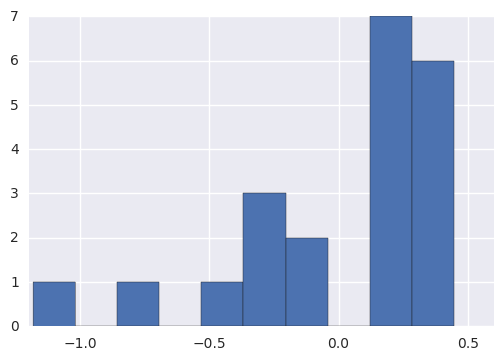

In [129]:
technology_models_fit_parameters['price~N(mu+beta,sigma)'].ix['beta'].hist()

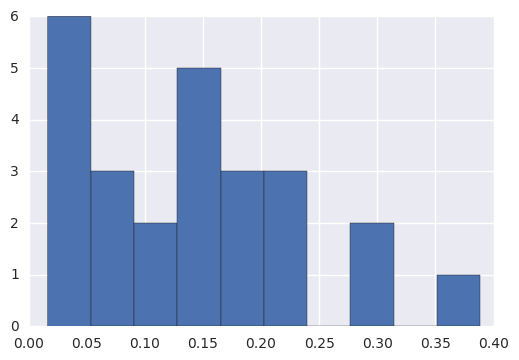

In [130]:
technology_models_fit_parameters['improvement~N(mu+beta,sigma)'].ix['beta'].hist()

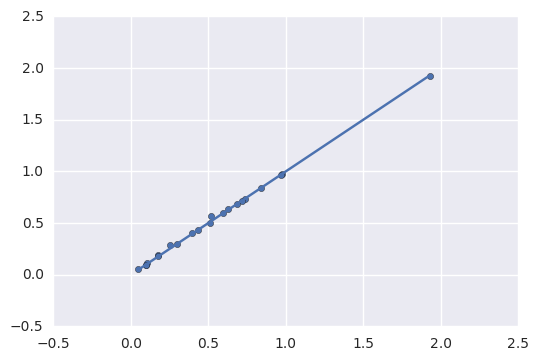

In [133]:
x = technology_models_fit_parameters['price~N(mu+beta,sigma)'].ix['sigma']
y = technology_models_fit_parameters['price~N(mu,sigma)'].ix['sigma'].ix[x.index]
scatter(x,y)
plot(sort(x), sort(x))

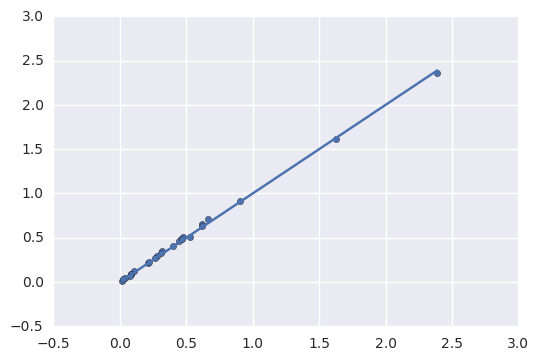

In [131]:
x = technology_models_fit_parameters['improvement~N(mu+beta,sigma)'].ix['sigma']
y = technology_models_fit_parameters['improvement~N(mu,sigma)'].ix['sigma'].ix[x.index]
scatter(x,y)
plot(sort(x), sort(x))

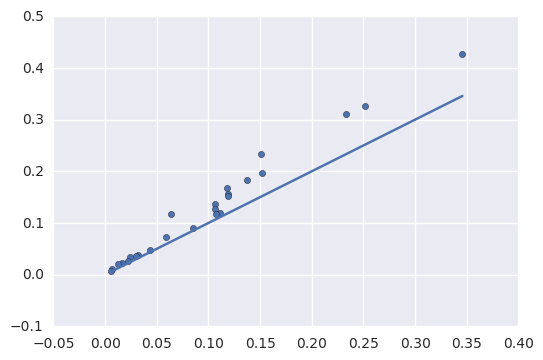

In [375]:
x = technology_models_fit_parameters['improvement~N(mu+beta,sigma)'].ix['mu']
y = technology_models_fit_parameters['improvement~N(mu,sigma)'].ix['mu'].ix[x.index]
scatter(x,y)
plot(sort(x), sort(x))

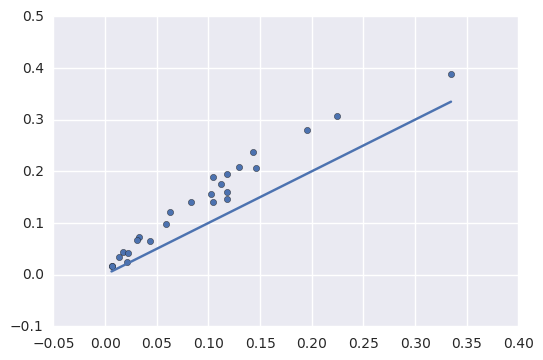

In [132]:
x = technology_models_fit_parameters['improvement~N(mu+beta,sigma)'].ix['mu']
y = technology_models_fit_parameters['improvement~N(mu+beta,sigma)'].ix['beta']
scatter(x,y)
plot(sort(x), sort(x))

THINGS TO DO:
---
    - Lags
    - Additional predictors
    - Prediction
    - Changes in value, instead of level
    - Additional predictors
        - - Patent count
        - - No. Backward citations
        - - Everything from Benson and Magee
    - Build some proper modules and break out of the notebook workflow?

In [ ]:
# base_time_series_program="""
# functions{
#     %(functions)s
# }

# data {
#     int N_technologies;
#     int N_updates;
#     vector[N_updates] observed_updates;
#     int updates_tech_inds[N_updates];
    
#     int tech_starts[N_technologies];
#     int tech_stops[N_technologies];
    
#     real first_observation_value[N_technologies];
#     int first_observation[N_technologies];
#     int last_observation[N_technologies];  
#     int backcast_to_observation;
#     int forecast_to_observation;
    
    
#     int N_gaps;
#     real gap_heights[N_gaps];
#     int gap_lengths[N_gaps];
    
#     int N_gap_updates;

#     int n_predictors;
#     matrix[N_technologies*N_updates, n_predictors] predictors;
#     %(priors)s
# }

  
# parameters {
#     vector%(update_raw_bounds)s[N_gap_updates] gap_updates_raw; // inferred updates between first and last observations

#     %(parameters)s    
# }

# transformed parameters {
#     //vector[N_time_steps_to_fit] Y_latent; // value each time period
#     vector%(update_bounds)s[N_gap_updates] gap_updates;
#     vector%(update_bounds)s[N_updates] updates;
    
#     {
#     int latest_gap_position;
#     latest_gap_position = 1;
#     for(i in 1:N_gaps){
#         gap_updates[latest_gap_position:latest_gap_position+gap_lengths[i]] = 
#         gap_updates_raw[latest_gap_position:latest_gap_position+gap_lengths[i]]/
#         sum(gap_updates_raw[latest_gap_position:latest_gap_position+gap_lengths[i]]) 
#         * gap_heights[i];
#         latest_gap_position = latest_gap_position + gap_lengths[i] + 1;
#     }
#     }
    
#     {
#     int gap_ind;
#     gap_ind = 1;
#     for (u in 1:N_updates){
#         if (observed_updates[u]!=-999.0){
#             updates[u] = observed_updates[u];
#         }
#         else{
#             updates[u] = gap_updates[gap_ind];
#             gap_ind = gap_ind + 1;
#         }
        
#     }
#     }
# }

# model {
#     %(model)s
# }

# generated quantities {

#     matrix[forecast_to_observation,N_technologies] Y_sim;
    
#     {
#     int updates_ind;
#     updates_ind = 1;
#     for (tech in 1:N_technologies){
#         Y_sim[first_observation[tech], tech] = first_observation_value[tech];
#         Y_sim[first_observation[tech]+1:
#               first_observation[tech]+1+tech_stops[tech]-tech_starts[tech],
#               tech] = cumulative_sum(updates[tech_starts[tech]:tech_stops[tech]]) 
#                       + rep_vector(first_observation_value[tech], tech_stops[tech]-tech_starts[tech]+1);
#     }
#     }

#     {
#     real update_size;
#     //Fill out future data points
#     for (tech in 1:N_technologies){
#         for(t in last_observation[tech]+1:forecast_to_observation){
#             %(update_size)s
#             Y_sim[t, tech] = update_size + Y_sim[t-1, tech];
#         }
#     }
#     }

#     //Fill out past data points
#     {
#     int t;
#     real update_size;
#     for (tech in 1:N_technologies){
#         t = first_observation[tech];
#         while(t>backcast_to_observation){
#             %(update_size)s
#             Y_sim[t-1, tech] = Y_sim[t, tech] - update_size;
#             t = t-1;
#         }
#     }
#     }
# }
# """

In [ ]:
# model_name = 'improvement~N(mu,sigma)'
# models[model_name] = {}
# models[model_name]['code'] = base_time_series_program%{

# ### model
# 'model': """
#     mu ~ normal(mu_prior_location, mu_prior_scale);
#     sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);

#     target += lower_truncated_normal_lpdf_vector(updates, mu[updates_tech_inds], sigma[updates_tech_inds], 0.0);
# """,

# ### parameters
# 'parameters': """
#     vector<lower = 0>[N_technologies] mu;
#     vector<lower = 0>[N_technologies] sigma;
# """,
    
# #### priors
# 'priors':"""
#     real mu_prior_location;
#     real mu_prior_scale;

#     real sigma_prior_location;
#     real sigma_prior_scale;
# """,

# ### increase size
# 'update_size': """
#     // Stan cannot yet generate numbers from a truncated distribution directly, so we have to do this silly thing. 
#     // As of version 2.12.0, the devs are still talking about it: https://github.com/stan-dev/math/issues/214
#     update_size = -1.0;  
#     while (update_size<0){
#         update_size = normal_rng(mu[tech],sigma[tech]);
#     }
# """,

# ### functions
# 'functions':"""
#     real lower_truncated_normal_lpdf_vector(vector x, vector mu, vector sigma, real A) {
#             return(normal_lpdf(x | mu, sigma) - normal_lccdf(A | mu, sigma));
#     }
# """,
    
# ### update bounds (Dictates if updates can only be positive, only negative, or both. Give the empty string for both.)
# 'update_bounds':"""<lower = 0>""",
# 'update_raw_bounds':"""<lower = 0, upper = 1>""",
# }

# models[model_name]['model_parameters'] = ['mu', 'sigma']
# models[model_name]['parameter_priors'] = {
#     'mu_prior_location': 0,
#     'mu_prior_scale': 3,
#     'sigma_prior_location': 0,
#     'sigma_prior_scale': 2,
#     }

# models[model_name]['stan_model'] = StanModel(model_code=models[model_name]['code'])

In [177]:
def predict_with_model(model_name, 
                       time_series,
                       training_years,
                       horizons,
                       time_series_from_each_time_period,
                       technology_forecast_models_log_pd,
                       technology_forecast_models_parameters,
                       technology_forecast_models_95CI,
                       target_tech_names,
                       model_code=None, 
                       model_parameters=None,
                       parameter_priors=None,
                       print_output=True):
    
    if model_code is None:
        model_code = models[model_name]['code']
    if model_parameters is None:
        model_parameters = models[model_name]['model_parameters']
    if parameter_priors is None:
        parameter_priors = models[model_name]['parameter_priors']
    
    technology_forecast_models_log_pd[model_name] = pd.Panel(items=target_tech_names,
         major_axis=horizons, 
         minor_axis=training_years)
    technology_forecast_models_95CI[model_name] = pd.Panel(items=target_tech_names,
         major_axis=horizons, 
         minor_axis=training_years)
    
    technology_forecast_models_parameters[model_name] = pd.Panel(items=target_tech_names,
             major_axis=model_parameters, 
             minor_axis=training_years)

    technology_forecast_models_Y_sim[model_name] = {}
    for training_year in training_years:
        print(training_year)

        forecast_start_ind = int(training_year-first_year)
        time_series_from_time_period = time_series_from_each_time_period[training_year]
        n_time_series_from_time_period = len(time_series_from_time_period)

        stan_data = stan_data_from_Y(time_series.ix[:training_year, 
                                                    time_series_from_time_period],
                                    forecast_to_observation=time_series.shape[0])
        stan_data = {**stan_data, **parameter_priors} 

        ###
        model_fit = models[model_name]['stan_model'].sampling(data=stan_data, n_jobs=n_jobs)
        Y_sim = model_fit['Y_sim']
        technology_forecast_models_Y_sim[model_name][training_year] = Y_sim
        
        if print_output:
            print(_print_stanfit(model_fit, model_parameters))
        for parameter in model_parameters:
            technology_forecast_models_parameters[model_name].ix[time_series_from_time_period, 
                                                        parameter,
                                                        training_year] = model_fit[parameter].mean(axis=0)

        for horizon in horizons:
            if horizon=='all':
                forecast_stop_ind = time_series.shape[0]
            else:
                forecast_stop_ind = horizon+forecast_start_ind
            
            times, techs = where(time_series[time_series_from_time_period].notnull())
            techs_to_forecast = techs[(forecast_start_ind<times)*(times<forecast_stop_ind)]
            times_to_forecast = times[(forecast_start_ind<times)*(times<forecast_stop_ind)]
            lpd = list(map(lambda x,y: x.logpdf(y)[0], 
                           map(gaussian_kde, Y_sim[:,times_to_forecast,techs_to_forecast].T), 
                           time_series[time_series_from_time_period].values[times_to_forecast, techs_to_forecast]))

            lpd = array(lpd)
            lpd[lpd==-inf] = log(finfo('d').tiny)
            lpd = pd.groupby(pd.Series(lpd),techs_to_forecast).sum()
            lpd = lpd.reindex(arange(len(time_series_from_time_period)))
            lpd.index = time_series_from_time_period
            technology_forecast_models_log_pd[model_name].ix[time_series_from_time_period,
                                                                 horizon,training_year] = lpd
            CI95 = portion_of_forecast_within_CI(model_fit, 'Y_sim', 
                                                 time_series[time_series_from_time_period].values, 
                                                 forecast_start_ind, 
                                                 forecast_stop_ind)
            technology_forecast_models_95CI[model_name].ix[time_series_from_time_period,
                                                           horizon,training_year] = CI95

In [ ]:
for model_name in [#'improvement~logN(mu,sigma), hierarchical', 
#                    'improvement~BCN(mu,sigma), hierarchical', 
                   #'improvement~N(mu,sigma), hierarchical', 
                   #'improvement~bernoulli(theta)N(mu,sigma)'
                    ]:
    if 'price' in model_name:
        continue
    print(model_name)
    predict_with_model(model_name,
                       time_series=empirical_time_series,
                       training_years=training_years, horizons=horizons,
                       time_series_from_each_time_period=performance_time_series_from_each_time_period,
                       technology_forecast_models_log_pd=performance_technology_forecast_models_log_pd,
                       technology_forecast_models_parameters=performance_technology_forecast_models_parameters,
                       technology_forecast_models_95CI=performance_technology_forecast_models_95CI,
                       target_tech_names=target_tech_names)